In [1]:
__version__ = '20201120'

# [NOIRLab](https://nationalastro.org/) - [Astro Data Archive](https://astroarchive.noao.edu/): [Advanced Search](https://astroarchive.noao.edu/api/docs/)


[Community Science and Data Center](https://nationalastro.org/programs/csdc/)

### Table Of Contents:
* [Goals & notebook summary](#goals)
* [Summary of this API (list of web services)](#summary)
* [Imports and setup](#init)
* [Details](#details); Example of every service. Special cases. Error Handling
  * [Verify API Version](#version)

  * [Get Core File fields](#core_file)
  * [Get Aux File fields](#aux_file)
  * [Search Files](#file_search)
    * [Find files that are downloadable by guest (not proprietary)](#find_downloadable)
    * [Get a URL that can be used to retrieve a FITS file](#get_retrieve_url)
    * [Examples of Search Constraints](#constraint_examples)
  * [Find public data](#get_public) 
  * [Get Core HDU fields](#core_hdu)
  * [Get Aux HDU fields](#aux_hdu)
  * [Search HDUs](#hdu_search)
  
* [What if something goes wrong](#errors) (errors)

* [Resources and references](#doc)
* [Glossary](#glos)



<a class="anchor" id="goals"></a>
# Goals
Instructions and examples for using Advanced Search API for accessing OIRLab Archive metadata.

# Notebook Summary
We show you how to use the API to search the Archive for FITS files by **any** field in the FITS headers.

Note that the Archive maintains separate metadata tables for the Primary FITS HDUs (referred to as FitsFiles throughout) and the HDU extensions (referred to as HDUs throughout), and thus there are separate services for each.  When constructing a query, the user should first consider whether the information needed is something that would apply to the entire focal plane of the instrument (and so would want to use the FitsFile services), or whether searching the HDU extensions is needed (requiring use of the HDU services).  In addition, both the FitsFile and HDU tables have sets of "Core" and "Auxiliary" header fields, where the Core fields are optimized for fast searches. 

Because the data volume is orders of magnitude smaller, the FitsFile services are considerably faster.  Using only Core fields in a search will also substantially increase speed.  For an example that uses both FitsFile and HDU searches, as well as a mix of Core and Aux fields, see the exposure-map.ipynb notebook in this repository.

The _fasearch_ and _hasearch_ service calls use a _limit_ parameter which reduces the amount of output and may speed up the search.  If you don't think you are getting all your results, increase the limit parameter!  The limit defaults to something low to avoid accidentaly running very long searches. 

## Summary of this API (list of web services) <a id="summary">
For full list, see: [/api/docs/#/api](https://astroarchive1.dm.noao.edu/api/docs/#/api)

1. [GET] `{ADS}/aux_file_fields/{instrument}/{proctype}/`
   Get fieldnames available from FitsFiles.
3. [GET] `{ADS}/aux_hdu_fields/{instrument}/{proctype}/`
   Get fieldnames available from HDUs.
5. [GET] `{ADS}/core_file_fields/`
7. [GET] `{ADS}/core_hdu_fields/`
9. [POST] `{ADS}/fasearch/`
11. [POST] `{ADS}/hasearch/`

Services of form `core_<type>_fields` (where <type> is one of: "file","hdu") return the list of optimized fields you can search against. 

Services of form `aux_<type>_fields` (where <type> is one of: "file","hdu") are used to return ALL of the FITS header field names that are not alreay included in the "core" lists.  These services require a specific Instrument and Proc_type [define!!!] be given. These fields have no search optimizations so using any of these will slow down your searches.

Services of form `fasearch` or `hasearch` (File/Hdu Advanced SEARCH) perform a search against full FITS files. They are accessed via a  HTTP POST (link) that takes a search specification in its JSON payload.


## Imports and setup <a id="init">
Some of this is just for presentation in the juypter notebook.  You may not need it all.

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.utils as autils
import requests
import json
from pprint import pprint as pp  # pretty print

print(f'Using Python version: {sys.version}\n')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]

This Jupyter Notebook uses (some of) these packages:

#pandas==0.23.4
pandas==1.1.4
#matplotlib==3.0.2
matplotlib==3.3.3
#ipython==7.2.0
jupyter==1.0.0
#requests==2.22.0
requests==2.25.0
#astropy==3.2.1
astropy==4.1
#pytest==5.3.5
pytest==6.1.2
healpy==1.14.0



In [3]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

adsurl = f'{natroot}/api/adv_search'
adsurl

Using server on https://astroarchive.noirlab.edu
About NSF's OIR Lab Astro Data Archive: https://astroarchive.noirlab.edu/about/


'https://astroarchive.noirlab.edu/api/adv_search'

## Details <a id="details">
    
* [Verify API Version](#version)
    
* [Get Core File fields](#core_file)    
* [Get Aux File fields](#aux_file)
* [Search Files](#file_search)
  
* [Get Core HDU fields](#core_hdu)
* [Get Aux HDU fields](#aux_hdu)
* [Search HDUs](#hdu_search)
  
* [What if something goes wrong](#errors) (errors)

Notes: 
- `File` fields and searches refer to the Primary HDU of a FITS file. (the field names may be a little different from how they appear in the FITS header since not all FITS headers use the same keywords for the same thing.)  

- `HDU` fields and searches refer to the non-primary HDUs of a FITS file. There are up to 70 times more HDU records as File records (depending on the source of the FITS file).

- All of these web services accept a `format` parameter in the HTTP query string.  This defines the format of the output. It can be one of: json (the default), csv, xml

- For the sake readability in this notebook, output is often stored in a Pandas DataFrame for display.

- Searches in this notebook use a `limit` parameter to reduce the number of records returned.

- Strings accept search modifiers: _exact, iexact, startswith, istartswith, endswith, iendswith, contains, icontains, regex, iregex_ (as described in [Django QuerySet API](https://docs.djangoproject.com/en/2.2/ref/models/querysets/)

## Verify API Version  <a id="version" />

In [4]:
actual_api = float(requests.get(f'{natroot}/api/version').content)
expected_api = 5.0
if int(actual_api) > int(expected_api):
    msg = f'This notebook needs to be updated to work with API Version {actual_api}'
    print(msg)
    raise Exception(msg)
else:
    print(f'Current server API version ({actual_api}) is good for this notebook.')


Current server API version (5.0) is good for this notebook.


## Get Core and Aux fields for Files and HDUs
Retrieve list of fields (with data-types) to use later in specifying which fields to filter and which ones to return in the filtered results.
### Get Core File field names and types <a id="core_file" />
These occur once per FITS file and are optimized for fast search. Output is field-name, data-type pairs.  The data-types are intended to be used with Pandas. Note that "catagory" types refer to relatively small sets of acceptable values.  These sets have values added to them occasionally.

In [5]:
pd.DataFrame(requests.get(f'{adsurl}/core_file_fields').json()).transpose()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Field,archive_filename,caldat,dateobs_center,dateobs_max,dateobs_min,dec_center,dec_max,dec_min,depth,exposure,...,ra_max,ra_min,release_date,seeing,site,survey,telescope,updated,url,user
Type,str,datetime64,datetime64,datetime64,datetime64,np.float64,str,str,np.float64,np.float64,...,str,str,datetime64,np.float64,category,category,category,datetime64,str,str
Desc,Filename assigned by the Archive,Local observing calendar date,DATE-OBS midpoint of range,"DATE-OBS min,max","DATE-OBS min,max",DEC midpoint in decimal degrees,DEC center from pipeline processing,DEC center from pipeline processing,from hdr=PHOTDPTH,from hdr=EXPTIME,...,RA center from pipeline processing,RA center from pipeline processing,Calculated,from hdr=SEEING,Telescope / observatory locale from which orig...,,Name of the telescope from which original raw ...,When Hdu created/updated,Access URL. Used to retrieve image,Constrain File by Principal Investigator or Co-PI


### Get allowable values for all Categories (see above for fields that are categories)
Fields that are Categories have a fixed number of valid values, and have Type=category. 

In [6]:
requests.get(f'{adsurl}/cat_lists/?format=json').json()

{'instruments': ['(p)odi',
  '90prime',
  'andicam',
  'arcoiris',
  'arcon',
  'bench',
  'ccd_imager',
  'ccd_spec',
  'chiron',
  'cosmos',
  'cpapir',
  'decam',
  'echelle',
  'falmingos',
  'flamingos',
  'goodman',
  'goodman spectrograph',
  'gtcam',
  'hdi',
  'ice',
  'ir_imager',
  'ispi',
  'kosmos',
  'minimo/ice',
  'mop/ice',
  'mosaic',
  'mosaic3',
  'mosaic_1',
  'mosaic_1_1',
  'mosaic_2',
  'newfirm',
  'osiris',
  'pfccd',
  'sami',
  'soi',
  'spartan',
  'spartan ir camera',
  'triplespec',
  'wfc',
  'whirc',
  'wildfire',
  'y4kcam'],
 'obsmodes': ['acq', 'imaging', 'sos_slit', 'spec'],
 'obstypes': ['acq',
  'acquire',
  'bias',
  'calibration',
  'calibration or comparison',
  'comp',
  'comparison',
  'dark',
  'dflat',
  'dome flat',
  'dome or projector flat',
  'domeflat',
  'flat',
  'focus',
  'fringe',
  'fringecor',
  'guider',
  'illum',
  'illumcor',
  'illumination calibration',
  'junk',
  'nota',
  'obj',
  'object',
  'phot flat',
  'photometric

### Get Aux File field names and types <a id="aux_file" />
These occur once per FITS file but will be slower to search.  All keywords from the Primary HDU (except those in Core File Fields) are included. All types default to "str", but will refine these in future.

In [7]:
requests.get(f'{adsurl}/aux_file_fields/decam/instcal/').json()

[{'Field': 'AIRMASS', 'Type': 'str', 'Desc': 'airmass'},
 {'Field': 'AOS', 'Type': 'str', 'Desc': 'AOS data available if true'},
 {'Field': 'ASTIG1', 'Type': 'str', 'Desc': '4MAPS correction 1'},
 {'Field': 'ASTIG2', 'Type': 'str', 'Desc': '4MAPS correction 2'},
 {'Field': 'ATTNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSIG', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSKY', 'Type': 'str', 'Desc': ''},
 {'Field': 'AZ', 'Type': 'str', 'Desc': 'Telescope azimuth'},
 {'Field': 'BAND', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAM', 'Type': 'str', 'Desc': 'BCAM data available if true'},
 {'Field': 'BCAMAX',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about x-axis'},
 {'Field': 'BCAMAY',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about y-axis'},
 {'Field': 'BCAMAZ',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about z-axis'},
 {'Field': 'BCAMDX', 'Type': 'str', 'Desc': '[micron] BCAM hexapod x-offset'},
 {'Field': 'BCAMDY', 'Type': 'str', 'Desc': '[micron] 

## Advanced File Search of Core and Aux fields, results into Pandas 
An Advanced Search is constructed in JSON format, and needs to specify what fields will be retrieved ("outfields") as well as what fields and constraints will be used to search the database ("search").  Fields of type Category need to be given exact values in Search, with multiple possible category values listed in sequence.  Fields of numeric or date types can be specified by a range of values.  For fields with string types, there are a number of modifiers that can be used to perform string expressions; see the section below on string constraints.

### Search Files <a id="file_search" />
- Use Database derived field, "ra_min"
- Use _AUX_ field in output and search
- Limit maximum number of results (rows) returned
- Load results into [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html#pandas.DataFrame)

In [8]:
jj = {
    "outfields" : [
        "md5sum",
        "ra_min",  # "ra" is a "range_field" in Postgres, access either part of range
        "archive_filename",
        "instrument",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
        "caldat",
        "EXPNUM",    # AUX field. Slows search
        "AIRMASS",
    ],
    "search" : [
        ["instrument", "decam"],
        ["proc_type", "raw", "instcal"],
        ["ra_min",322,324],
        ["EXPNUM", 667000, 669000],
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=20'
print(f'Using API url: {apiurl}')
pd.DataFrame(requests.post(apiurl,json=jj).json()[1:])

Using API url: https://astroarchive.noirlab.edu/api/adv_search/fasearch/?limit=20


,md5sum,archive_filename,instrument,proc_type,obs_type,release_date,proposal,caldat,ra_min,EXPNUM,AIRMASS
0,0043a1d272226352397a335aa50a7892,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,323.368750,667101,1.19
1,05b728bd114c938485b2b5f85946fb7a,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,322.496667,667109,1.44
2,090f2c5876fdd5db4e3351c7c142fb07,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,322.496708,667112,1.45
3,0b234f7ea5d640e19212fb0a300c7c12,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,322.496458,667110,1.44
4,0ed4bc7af8c19e2f601f439c587a8bff,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,323.367500,667104,1.20
5,10ca3658469336b34d836967b9df26c1,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,decam,raw,object,2017-09-13,2017B-0951,2017-08-14,322.493042,667098,1.40
6,114eae4ee047f89edd35974a8738ace9,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,323.366625,667091,1.17
7,12bceb730822dda3419864b879fca0c5,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,322.496833,667096,1.40
8,16299107fcae8cc42ce289c9c9959ada,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,323.365917,667094,1.17
9,17de05eb4d8e8d1cc889dcf923be1d9e,/net/archive/pipe/20170814/ct4m/2017B-0951/c4d...,decam,instcal,object,2017-09-13,2017B-0951,2017-08-14,322.497250,667107,1.44


#### Search for a range of dates.

In [9]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
        "caldat",
    ],
    "search" : [
        ["instrument", "decam"],
        ["caldat", "2017-02-11", "2018-04-17"],  # limit to date range
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=10'
print(f'Using API url: {apiurl}')
pd.DataFrame(requests.post(apiurl,json=jj).json()[1:])

Using API url: https://astroarchive.noirlab.edu/api/adv_search/fasearch/?limit=10


,md5sum,archive_filename,instrument,proc_type,obs_type,release_date,proposal,caldat
0,000007c08dc11d70622574eec3819a02,/net/archive/pipe/20170621/ct4m/2017A-0388/c4d...,decam,instcal,object,2018-12-13,2017A-0388,2017-06-21
1,00000bfb859daa4898b55659c1f348fc,/net/archive/pipe/20170211/ct4m/2016B-0301/c4d...,decam,resampled,object,2018-08-05,2016B-0301,2017-02-11
2,00000ec8ac45d5f1b37645dcd20bb270,/net/archive/pipe/20180417/ct4m/2018A-0913/c4d...,decam,skysub,object,2019-10-09,2018A-0913,2018-04-17
3,000015f875c4cfb0e1e13475c170267f,/net/archive/pipe/20171021/ct4m/2012B-0001/c4d...,decam,instcal,object,2018-10-16,2012B-0001,2017-10-21
4,000020cee9d097a4c386d092198c8a76,/net/archive/pipe/20180114/ct4m/2012B-0001/c4d...,decam,resampled,object,2019-01-09,2012B-0001,2018-01-14
5,00002b202fd60413b1333e2ea256bcdd,/net/archive/pipe/20170424/ct4m/2017A-0060/c4d...,decam,skysub,object,2018-10-16,2017A-0060,2017-04-24
6,00002d1254a5a7f872c8a7982fcb52b9,/net/archive/pipe/20170303/ct4m/2014B-0404/c4d...,decam,instcal,object,2018-08-25,2014B-0404,2017-03-03
7,0000467de481b78b286303fe6495c52f,/net/archive/pipe/20170921/ct4m/2014B-0404/c4d...,decam,instcal,object,2019-03-15,2014B-0404,2017-09-21
8,00006f0753b9e63f50f40d185e6cbd39,/net/archive/pipe/20180226/ct4m/2018A-0251/c4d...,decam,resampled,object,2019-08-20,2018A-0251,2018-02-26
9,00008286b174523e141b3b14bdd0f3f6,/net/archive/pipe/20170330/ct4m/2014B-0404/c4d...,decam,instcal,object,2018-09-21,2014B-0404,2017-03-30


### Find files available for download <a id="find_downloadable" />
You can comment one or the other of the "release_date" search lines to find either public files or proprietary files.
You can retrieve the public files without authentication. But to retrieve the proprietary files you must be an authenticated PI of a proposal associated with the file. Metadata has no proprietary period.

In [10]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "telescope",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
        "url",
    ],
    "search" : [
        ["release_date", '2005-02-18','2020-01-20'], # public
        #["release_date", '2020-02-18','2020-11-18'], # proprietary
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=50'
print(f'Using API url: {apiurl}')

ads_df = pd.DataFrame(requests.post(apiurl,json=jj).json()[1:])
ads_df

Using API url: https://astroarchive.noirlab.edu/api/adv_search/fasearch/?limit=50


,md5sum,archive_filename,instrument,telescope,proc_type,obs_type,release_date,proposal,url
0,0000004ab27d9e427bb93c640b358633,/net/archive/pipeline/Q20110409/C4M11A/2011040...,mosaic_2,ct4m,instcal,object,2012-09-28,2011A-0477,https://astroarchive.noirlab.edu/api/retrieve/...
1,0000041587917c9cb234c6116b396394,/net/archive/mtn/20140121/kp4m/2013B-0395/kp19...,flamingos,kp4m,raw,object,2015-07-15,2013B-0395,https://astroarchive.noirlab.edu/api/retrieve/...
2,0000065ee227de201686b54706ba58e9,/net/archive/pipeline/Q20150727/DEC15A/2015072...,decam,ct4m,resampled,object,2017-01-13,2015A-0618,https://astroarchive.noirlab.edu/api/retrieve/...
3,0000079ed58542c36a059467cc748420,/net/archive/pipeline/Q20161102/K4N16B/2016101...,newfirm,kp4m,instcal,object,2018-04-10,2013B-0236,https://astroarchive.noirlab.edu/api/retrieve/...
4,000007c08dc11d70622574eec3819a02,/net/archive/pipe/20170621/ct4m/2017A-0388/c4d...,decam,ct4m,instcal,object,2018-12-13,2017A-0388,https://astroarchive.noirlab.edu/api/retrieve/...
5,0000088eabc78f332e82ccfe7f4c2f8e,/net/archive/mtn/20140824/soar/2014B-0602/psg_...,goodman,soar,raw,object,2016-02-15,2014B-0602,https://astroarchive.noirlab.edu/api/retrieve/...
6,00000987d6968004b925030189ad24b9,/net/archive/pipeline/Q20130905/DEC13B/2013081...,decam,ct4m,instcal,object,2015-02-09,2013B-0325,https://astroarchive.noirlab.edu/api/retrieve/...
7,00000988249dc6de0b691c273d78b483,/net/archive/mtn/20080226/ct13m/smarts/c13a_08...,andicam,ct13m,raw,object,2009-08-19,smarts,https://astroarchive.noirlab.edu/api/retrieve/...
8,00000ab765f13191e19977d63071550c,/net/archive/pipeline/Q20150106/DESY1/20131204...,decam,ct4m,instcal,object,2014-11-29,2012B-0001,https://astroarchive.noirlab.edu/api/retrieve/...
9,00000bfb859daa4898b55659c1f348fc,/net/archive/pipe/20170211/ct4m/2016B-0301/c4d...,decam,ct4m,resampled,object,2018-08-05,2016B-0301,https://astroarchive.noirlab.edu/api/retrieve/...


#### Get a URL that can be used to retrieve a single public FITS file.   <a id="get_retrieve_url" />
Pasting this in your browser will result in dialog box that lets you save the file locally.

In [11]:
selectedRow=0
ads_df['url'][selectedRow]
# https://marsnat1.stage.dm.noao.edu/api/adv_search/retrieve/0000004ab27d9e427bb93c640b358633/'
ads_df['url'][selectedRow]

'https://astroarchive.noirlab.edu/api/retrieve/0000004ab27d9e427bb93c640b358633/'

#### This gets no results (no Archive filename ends with "BADSUFFIX")
The "archive_filename" is a string type so there are many modifiers that can be used with it: 
_exact, iexact, startswith, istartswith, endswith, iendswith, contains, icontains, regex, iregex_

This yields a Pandas DataFrame that has no rows. The names of all files in the archive are searched. (currently about 10 million files) Caching of results may cause your search time to be suspiciously short.

In [12]:
jj = {
    "outfields" : ["archive_filename", "md5sum"],
    "search" : [
        ["archive_filename", "k4m_170308_045842_ori.fits.fz.BADSUFFIX", 'endswith'],
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

""


### Example of each type of search constraint <a id="constraint_examples" />

##### STRING constraints
Allowable modifiers:
- exact (default)
- iexact
- startswith
- istartswith
- endswith
- iendswith
- contains
- icontains
- regex
- iregex

##### Exact modifier

In [13]:
jj = {
    "outfields" : ["archive_filename"],
    "search" : [
        ["md5sum", "040b009c3e2ab75dc477d884a45fd10f"], # modifier not given so "exact"
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

,archive_filename
0,/net/archive/mtn/20180505/soar/soar/psg_180506...


##### Startswith modifier

In [14]:
jj = {
    "outfields" : ["original_filename"],
    "search" : [
        ["original_filename", "/ua84", 'startswith'],
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

,original_filename
0,/ua84/mosaic/nicole/n2/obj2103.fits
1,/ua84/mosaic/song/20091117/obj13092.fits
2,/ua84/mosaic/Mohr/bcs081128/BCS0528-5009Oi.081...
3,/ua84/mosaic/Barkhouse/90206/CTIO_147Az.060903...
4,/ua84/mosaic/Mohr/bcs081125/BCS2344-5152Bg.081...
5,/ua84/mosaic/cole/n2/obj2104.fits
6,/ua84/mosaic/parker/night4/obj437.fits
7,/ua84/mosaic/nidever/n4/obj4145.fits
8,/ua84/mosaic/monelli/n3/obj3073.fits


##### Endswith modifier

In [15]:
jj = {
    "outfields" : ["original_filename"],
    "search" : [
        ["original_filename", "obj2104.fits", 'endswith'],
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

,original_filename
0,/ua84/mosaic/cole/n2/obj2104.fits
1,/ua84/mosaic/keeney/n2/obj2104.fits
2,/ua84/mosaic/yonsei/20080504/obj2104.fits
3,/ua85/mosaic/smsn/sm100510/obj2104.fits
4,/ua84/mosaic/sinnott/n2/obj2104.fits
5,obj2104.fits
6,/ua84/mosaic/nicole/n2/obj2104.fits
7,/ua84/mosaic/rmunioz/20101201/obj2104.fits
8,obj2104.fits


##### icontains modifier

In [16]:
jj = {
    "outfields" : ["original_filename"],
    "search" : [
        ["original_filename","Nicole", 'icontains'],
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

,original_filename
0,/ua84/mosaic/nicole/n2/obj2103.fits
1,/ua84/mosaic/nicole/n3/obj3012.fits
2,/ua84/mosaic/nicole/n1/obj1030.fits
3,/ua83/mosaic/nicole/90406/Musca17.I2044.fits
4,/ua84/mosaic/nicole/n1/obj1073.fits
5,/ua84/mosaic/nicole/n2/obj2074.fits
6,/ua83/mosaic/nicole/90406/Musca35.I2026.fits
7,/ua83/mosaic/nicole/90406/Musca17.I2036.fits
8,/ua84/mosaic/nicole/n1/obj1024.fits


##### iregex modifier  (regular expression)
See https://docs.python.org/3/library/re.html?highlight=regex

In [17]:
jj = {
    "outfields" : ["original_filename"],
    "search" : [
        ["original_filename",r"/(Cary|Cole)", 'iregex'],
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()[1:])

,original_filename
0,/ua84/mosaic/cole/n2/obj2104.fits
1,/ua83/mosaic/cole/n3/obj3116.fits
2,/ua83/mosaic/cole/n3/obj3078.fits
3,/ua83/mosaic/cole/n3/obj3104.fits
4,/ua83/mosaic/cole/n3/obj3075.fits
5,/ua84/mosaic/cole/n2/obj2116.fits
6,/ua83/mosaic/cole/n4/obj4086.fits
7,/ua84/mosaic/cole/n2/obj2129.fits
8,/ua84/mosaic/cole/n2/obj2095.fits


### Public files<a id="get_public" />
List files that are available to the public today and are from observations on a specific night associated with given proposal.

In [18]:
# getnight(propid, caldat)
import datetime

propid = '2012B-0001'
caldat = '2018-11-29'
today = datetime.date.today().isoformat()
print(f'Public as of {today}:')
jj = {
    "outfields" : ['archive_filename','original_filename', 
                   'release_date','caldat',
                   'instrument',
                   'proposal'],
    "search" : [
        ["release_date", '2005-02-18', today], # public as of today
        ["proposal", propid],
        ["caldat", caldat, caldat]
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=900',json=jj).json()[1:])

Public as of 2021-02-08:


,archive_filename,original_filename,release_date,caldat,instrument,proposal
0,/net/archive/mtn/20181129/ct4m/2012B-0001/c4d_...,/data_local/images/DTS/2012B-0001/DECam_007977...,2019-11-24,2018-11-29,decam,2012B-0001
1,/net/archive/mtn/20181129/ct4m/2012B-0001/c4d_...,/data_local/images/DTS/2012B-0001/DECam_007977...,2018-11-29,2018-11-29,decam,2012B-0001
2,/net/archive/mtn/20181129/ct4m/2012B-0001/c4d_...,/data_local/images/DTS/2012B-0001/DECam_007977...,2018-11-29,2018-11-29,decam,2012B-0001
3,/net/archive/pipe/20181129/ct4m/2012B-0001/c4d...,/data_local/images/DTS/2012B-0001/DECam_007977...,2019-11-24,2018-11-29,decam,2012B-0001
4,/net/archive/pipe/20181129/ct4m/2012B-0001/c4d...,/data_local/images/DTS/2012B-0001/DECam_007978...,2019-11-24,2018-11-29,decam,2012B-0001
...,...,...,...,...,...,...
895,/net/archive/pipe/20181129/ct4m/2012B-0001/c4d...,/data_local/images/DTS/2012B-0001/DECam_007980...,2019-11-24,2018-11-29,decam,2012B-0001
896,/net/archive/pipe/20181129/ct4m/2012B-0001/c4d...,/data_local/images/DTS/2012B-0001/DECam_007978...,2019-11-24,2018-11-29,decam,2012B-0001
897,/net/archive/pipe/20181129/ct4m/2012B-0001/c4d...,/data_local/images/DTS/2012B-0001/DECam_007979...,2019-11-24,2018-11-29,decam,2012B-0001
898,/net/archive/mtn/20181129/ct4m/2012B-0001/c4d_...,/data_local/images/DTS/2012B-0001/DECam_007979...,2019-11-24,2018-11-29,decam,2012B-0001


#### Get a night of data from a list of proposals.

In [19]:
caldat = '2016-11-29'
jj = {
    "outfields" : ['archive_filename', 'caldat', 'proposal'],
    "search" : [
        ["proposal", "smarts","2015B-0313"],
        ["caldat", caldat, caldat]
    ]
}
pd.DataFrame(requests.post(f'{adsurl}/fasearch/?limit=90',json=jj).json()[1:])

,archive_filename,caldat,proposal
0,/net/archive/mtn/20161129/ct13m/smarts/ct50815...,2016-11-29,smarts
1,/net/archive/mtn/20161129/ct13m/smarts/ct50783...,2016-11-29,smarts
2,/net/archive/mtn/20161129/ct13m/smarts/ct50783...,2016-11-29,smarts
3,/net/archive/mtn/20161129/ct13m/smarts/c13a_16...,2016-11-29,smarts
4,/net/archive/mtn/20161129/ct13m/smarts/ct50783...,2016-11-29,smarts
...,...,...,...
85,/net/archive/mtn/20161129/ct13m/smarts/c13a_16...,2016-11-29,smarts
86,/net/archive/mtn/20161129/ct13m/smarts/c13a_16...,2016-11-29,smarts
87,/net/archive/mtn/20161129/ct13m/smarts/ct50812...,2016-11-29,smarts
88,/net/archive/mtn/20161129/ct09m/smarts/c09i_16...,2016-11-29,smarts


### It is an error to search using AUX field without limiting to instrument
An error is raised if an AUX field is in the search clause without also searching for and *instrument* and *proc_type*. Uncommenting the *instrument* line below will fix the problem.

In [20]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "proc_type",
        "EXPNUM",    # AUX field. Slows search
    ],
    "search" : [
        #["instrument", "decam"],  # uncomment this to eliminate error
        ["proc_type", "raw"],
        ["EXPNUM", 667000, 669000],
    ]
}
requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()

{'errorMessage': 'No "instrument" was provided when searching for AUX fields. For performance reasons you must also filter on "instrument" and "proc_type" that contain the AUX fields you are searching on (EXPNUM).',
 'errorCode': 'MISINSTR'}

In [21]:
fileid = ads_df['md5sum'][0]
fileurl = f'{natroot}/api/retrieve/{fileid}'
fileurl

'https://astroarchive.noirlab.edu/api/retrieve/0000004ab27d9e427bb93c640b358633'

#### Attempt to get File
There are several reasons attempt may fail, so check status!  Most reasons only apply to Proprietary files and include: 
1. There is no proposal associated with the File
1. User is not authenticated
1. User is not a PI or CoPI associated with the proposal

For more details on retrieving proprietary files see the **api-authentication** notebook.

HTTP-Status=200 File-size=777,600


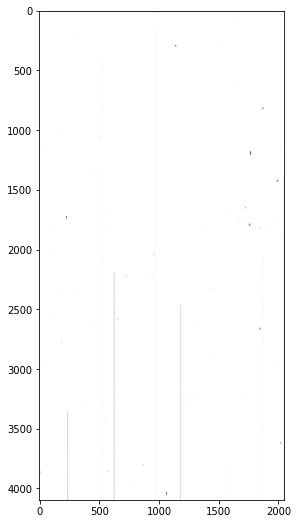

In [22]:
response = requests.get(fileurl)
if response.status_code == 200:
    print(f'HTTP-Status={response.status_code} File-size={len(response.content):,}')    
    zimage = pyfits.getdata(autils.data.download_file(fileurl,cache=True,show_progress=False,timeout=120))
    plt.rcParams["figure.figsize"] = [16,9]
    plt.imshow(zimage,cmap=matplotlib.cm.gray_r)
    zimage.shape
else:
    print(f'content={response.content}')
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use


### Get Core HDU field names and types <a id="core_hdu" />
These occur once per non-primary HDU and are optimized for fast search.

In [23]:
pd.DataFrame(requests.get(f'{adsurl}/core_hdu_fields').json()).transpose()

,0,1,2,3,4,5,6,7,8,9
Field,dec_center,dec_max,dec_min,fitsfile,hdu_idx,id,ra_center,ra_max,ra_min,updated
Type,np.float64,np.float64,np.float64,str,np.int64,str,np.float64,np.float64,np.float64,datetime64
Desc,DEC center from pipeline processing,DEC center from pipeline processing,DEC center from pipeline processing,,,,RA center from pipeline processing,RA center from pipeline processing,RA center from pipeline processing,When Hdu created/updated


### Get Aux HDU field names and types <a id="aux_hdu" />
These occur once per non-primary HDU but will be slower to search.  All keywords from the non-primary HDUs (except those in Core HDU Fields) are included.

In [24]:
requests.get(f'{adsurl}/aux_hdu_fields/decam/raw/').json()

[{'Field': 'AMPSECA',
  'Type': 'str',
  'Desc': 'CCD section in read order for amp A'},
 {'Field': 'AMPSECB',
  'Type': 'str',
  'Desc': 'CCD section in read order for amp B'},
 {'Field': 'BIASSECA', 'Type': 'str', 'Desc': 'Overscan from amp A'},
 {'Field': 'BIASSECB', 'Type': 'str', 'Desc': 'Overscan from amp B'},
 {'Field': 'BSCALE', 'Type': 'str', 'Desc': 'REAL = TAPE*BSCALE + BZERO'},
 {'Field': 'BUNIT', 'Type': 'str', 'Desc': 'photoelectrons per second'},
 {'Field': 'BZERO', 'Type': 'str', 'Desc': ''},
 {'Field': 'CCDBIN1', 'Type': 'str', 'Desc': 'Binning factor along axis 1'},
 {'Field': 'CCDBIN2', 'Type': 'str', 'Desc': 'Binning factor along axis 2'},
 {'Field': 'CCDNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'CCDSEC', 'Type': 'str', 'Desc': 'ccd section'},
 {'Field': 'CCDSECA', 'Type': 'str', 'Desc': 'CCD section from amp A'},
 {'Field': 'CCDSECB', 'Type': 'str', 'Desc': 'CCD section from amp B'},
 {'Field': 'CD1_1', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD1_

## Advanced HDU Search of Core and Aux fields, results into Pandas <a id="hdu_search" />  

In [25]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [26]:
%%time
jj = {
    "outfields" : [
        "fitsfile__archive_filename",
        "fitsfile__caldat",
        "fitsfile__instrument",
        "fitsfile__proc_type",
        "ra",
        "dec",
    ],
    "search" : [
        ["fitsfile__caldat", "2019-06-07", "2019-06-07"] ,
        ["fitsfile__instrument", "decam"],
        ["fitsfile__proc_type", "resampled"],
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/hasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.DataFrame(response.json()[1:])
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use

These OUTFIELDS fields are not known to exist in any loaded headers (dec, ra). Only files with instrument=decam and proctype=resampled are considered. Available fields are: ADDAST, ARAWGAIN, AVSIG, AVSKY, BACKFSIZ, BACKMEAN, BACKSIG, BACKSIZE, BACKSUBF, BACKTYPE, BIASFIL, BLDINTRP, BPM, BPMFIL, CCDNUM, CD1_1, CD1_2, CD2_1, CD2_2, CDELT1, CDELT2, CENDEC1, CENRA1, CENTERT1, CENTERT2, COMBINET, COMIN1, COMIN2, COR1DEC1, COR1RA1, COR2DEC1, COR2RA1, COR3DEC1, COR3RA1, COR4DEC1, COR4RA1, CRPIX1, CRPIX2, CRVAL1, CRVAL2, CTYPE1, CTYPE2, CUNIT1, CUNIT2, DATE, DEC1, DEC17A_2, DEC17B_2, DEC18A_2, DEC18B_2, DEC19A_2, DEC19A_D, DEC19A_P, DEC19B_A, DEC19B_D, DEC19B_F, DEC19B_J, DEC19B_S, DEC20A_J, DECALS_2, DES15B_2, DES16B_2, DES17A_2, DES17B_2, DES18A_2, DES18B_2, DESBFC, DESBIAS, DESBLEED, DESBPM, DESCRMSK, DESDCXTK, DESFLAT, DESGAINC, DESILLUM, DESLINC, DESOSCN, DESSAT, DESSTAR, DES_EXT, DETECTOR, DETPOS, DETSEC, ELLIPTIC, EQUINOX, EXPTIME, EXTNAME, EXTVER, FILTER, FIXPIX, FLASCALE, FLATFIL, FLA

KeyError: 'traceback'

In [27]:
df

## Error Conditions <a id="errors" />

### Examples of bad search specification
#### Attempt to search unknown field name

In [28]:
jj={
    "outfields" : [
        "ifilter",
        "archive_filename"
    ],
    "search" : [
        ["snafu","wubba"], # unknown field "snafu"
        ["instrument", "decam"]
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.DataFrame(response.json()[1:])
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use
df

No "proc_type" was provided when searching for AUX fields. For performance reasons you must also filter on "instrument" and "proc_type" that contain the AUX fields you are searching on (snafu).


#### Attempt to retrieve field name not in known list

In [29]:
jj={
    "outfields" : [
        "baz",  # unknown field
        "foo",  # unknown field
        "ifilter",
        "archive_filename"
    ],
    "search" : [
        ["ifilter", "GG395 kGG395"],
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.DataFrame(response.json()[1:])
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use
df



These OUTFIELDS fields are not known to exist in any loaded headers (baz, foo). Only files with instrument=None and proctype=None are considered. Available fields are: archive_filename, caldat, dateobs_center, dateobs_max, dateobs_min, dec_center, dec_max, dec_min, depth, exposure, filesize, ifilter, instrument, md5sum, obs_mode, obs_type, original_filename, proc_type, prod_type, proposal, ra_center, ra_max, ra_min, release_date, seeing, site, survey, telescope, updated, url, user. You can always retrieve these using aux_file_fields or aux_hdu_fields.


In [30]:
import datetime
elapsed = toc()  # Seconds since start of Notebook load (assuming fresh run)
print(f'Elapsed seconds={elapsed} on {natroot}')
print(f'Completed on: {str(datetime.datetime.now())}')
assert natroot == 'https://astroarchive.noirlab.edu', 'Notebook does NOT point to PRODUCTION'
elapsed

Elapsed seconds=199.30444037599955 on https://astroarchive.noirlab.edu
Completed on: 2021-02-08 15:51:35.674756


199.30444037599955

# Resources and references <a id="doc" />
- [automically generated API sepecifications](https://astroarchive.noao.edu/api/docs/#/api)
Generated using [swagger](https://drf-yasg.readthedocs.io/en/stable/readme.html) against annotated source code.

- [NOAO Data Handbook](http://ast.noao.edu/sites/default/files/NOAO_DHB_v2.2.pdf) version 2.2, May 2015